In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Problem 6.0   
> The fit value of Tm is 331.9 K which is in line with visual inspection of the data (where the peak is). The fit value of $\Delta$C$_p$ is 6.29 KJ/mol K which is also in line with visual inspection of the difference between the two baselines. The fit value of $\Delta$$\overline{H_m}$ is 396.2 KJ/mol which is in line with expectations as well as the heat capacity should be positive for the endothermic process of temperature unfolding and it is about what Dr. Barrick told us to expect for an unfolding transition with a range of around 15 K. Therefore, all of these fit values seem reasonable.

In [2]:
df = pd.read_csv('./DSC_data_scaled.txt', header=None, sep=' ')
Temps = df[0] #in Kelvin
dCp = df[1] #differential molar heat capacity in KJ/mol K


def differential_heat_capacity(T, Cp_d, DeltaCp, Tm, DeltaHm):
    R = 8.3145e-3 #IDG Contant in KJ/mol K
    Delta_G = DeltaHm - T*(DeltaHm/Tm)
    K = np.exp(-(Delta_G / (R * T)))
    fN = K / (1 + K)
    fD = 1 / (1 + K)
    
    Cp_pwa = Cp_d + fN * DeltaCp
    Cp_excess = fN*fD * DeltaHm**2 / (R*T**2)
    
    differential_Cp = Cp_pwa + Cp_excess
    
    return differential_Cp


guesses = [11, 7, 332.5, 400]
popt, pcov = curve_fit(differential_heat_capacity, Temps, dCp, guesses)
print(['Cp_d', 'DeltaCp', 'Tm', 'DeltaHm'], '=', popt)

['Cp_d', 'DeltaCp', 'Tm', 'DeltaHm'] = [  4.17179616   6.28907394 331.9146664  396.23614068]


### Problem 6.1    
> The midpoint of the C$_{p,PWA}$ curve corresponds to the peak of the fit curve which both occur at the predicted Tm (331.9 K).

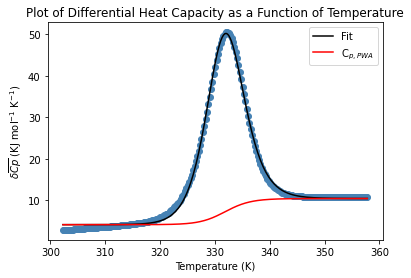

In [3]:

def pwa(T, Cp_d, DeltaCp, Tm, DeltaHm):
    R = 8.3145e-3 #IDG Contant in KJ/mol K
    Delta_G = DeltaHm - T*(DeltaHm/Tm)
    K = np.exp(-(Delta_G / (R * T)))
    fN = K / (1 + K)
    fD = 1 / (1 + K)
    
    Cp_pwa = Cp_d + fN * DeltaCp
    Cp_excess = fN*fD * DeltaHm**2 / (R*T**2)
    
    differential_Cp = Cp_pwa #+ Cp_excess
    
    return differential_Cp

pwas = pwa(Temps, *popt)

plt.plot(Temps, dCp, 'o', color='steelblue')
plt.plot(Temps, differential_heat_capacity(Temps, *popt) ,'k', label='Fit')
plt.plot(Temps, pwas, 'r',label='C$_{p, PWA}$')

plt.title("Plot of Differential Heat Capacity as a Function of Temperature")
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('$\delta$$\overline{Cp}$ (KJ mol$^{-1}$ K$^{-1}$)');

### Problem 6.2
> The simple Riemann sum function below returns an area of 396.2 KJ / mol. This is the same value as obtained for $\Delta$$\overline{H_m}$ from the curve fit! This indicates that the concentration of solution was measured accurately for the differential heat capacity data as it is not skewed up or down.

In [4]:
def riemann_sum(a, b, curve1, curve2, bin_width):
    '''
    Calculates a simple Riemann sum by finding the area as the sum of area of rectangles with height curve2 - curve1 and width bin_width from a to b. 
    '''
    sum = 0
    x = np.arange(a, b + bin_width, bin_width)
    
    vals1 = curve1(x, *popt)
    vals2 = curve2(x, *popt)
    for i,j in enumerate(x):
        h = vals2[i] - vals1[i]
        sum += h * bin_width
    return sum
    
area = riemann_sum(Temps[0], Temps[len(Temps)-1], pwa, differential_heat_capacity, 0.01)
print('Area:', area)

Area: 396.2236863897687


### Problem 6.6   
> The plot generated below shows that the log of the number of ways is maximized when the $\mathbb{N_i}$'s are all equal because the log(number of ways) is just a simple transformation applied to the trinomial distribution. This plot shows non-integer values for $\mathbb{N_2}$ and $\mathbb{N_3}$, but since there really only makes sense for the number of a particular microstate to be an integer value, the maximum number of arrangements is found when ($\mathbb{N_1}$, $\mathbb{N_2}$, $\mathbb{N_3}$) = (6,7,7) or (7,6,7) or (7,7,6)

<ipython-input-5-4909fb7d85cc>:28: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))


Integer Maxima: 
21.921346568937103
21.921346568937103
21.921346568937103


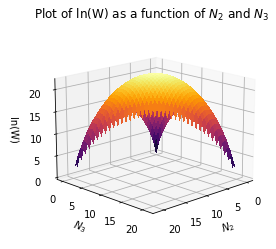

In [5]:
def log_number_of_ways(N2, N3):
    A = 20
    N1 = A - N2 - N3
    first = 0 if N1 <= 0 else N1 * np.log(N1) 
    second = 0 if  N2 <= 0 else N2 * np.log(N2)
    third = 0 if N3 <= 0 else N3 * np.log(N3)
    out = A*np.log(A) - ( first + second + third) if N1+N2+N3 <= A and N1 >= 0 else np.nan
    return out

N3 = N2 = np.arange(0, 21, .1)
X, Y = np.meshgrid(N2, N3)

out = []
for i,j in enumerate(X):
    row = []
    for k,l in enumerate(j):
        row.append(log_number_of_ways(l, Y[i][k]))
    out.append(row)

Z = np.array(out)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('$N_2$')
ax.set_ylabel('$N_3$')
ax.set_zlabel('ln(W)')
ax.set_title('Plot of ln(W) as a function of $N_2$ and $N_3$')
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))
ax.view_init(16, 46)


print("Integer Maxima: ")
print(log_number_of_ways(6,7))
print(log_number_of_ways(7,7))
print(log_number_of_ways(7,6))

### Problem 6.7

<ipython-input-6-305f0203520f>:7: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))


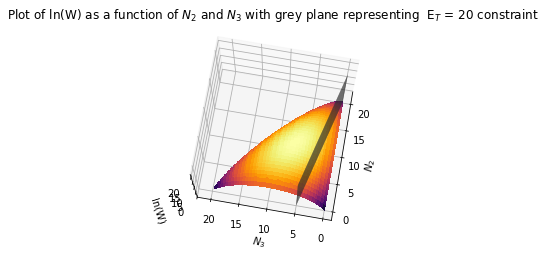

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('$N_2$')
ax.set_ylabel('$N_3$')
ax.set_zlabel('ln(W)')
ax.set_title('Plot of ln(W) as a function of $N_2$ and $N_3$ with grey plane representing  E$_T$ = 20 constraint')
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, vmin=log_number_of_ways(0,0), vmax = log_number_of_ways(20/3,20/3))

zs = ys = np.arange(0, 21, .1)

B, Q = np.meshgrid(ys, zs)
A = 20 - 4*B

A[A<0] = np.nan

surf2 = ax.plot_surface(A, B, Q, color='grey')
ax.view_init(75, -170)


In [7]:
_max = 0
I = 0
J = 0
for i in range(21):
    for j in range(21):
        n = log_number_of_ways(i, j) if 20 - i - j >= 0 and i == 20 - 4*j else 0
        if n > _max:
            I = i
            J = j
            _max = n
            
print(f'Maximum at (N1,N2,N3) = ({20-I-J}, {I}, {J}) where ln(W) = {_max:.5f}')

Maximum at (N1,N2,N3) = (9, 8, 3) where ln(W) = 20.20826


### Problem 6.8B     
> The mean of the data is 1987.5 and the most frequent replica energy was 2000.

Average:  1987.5


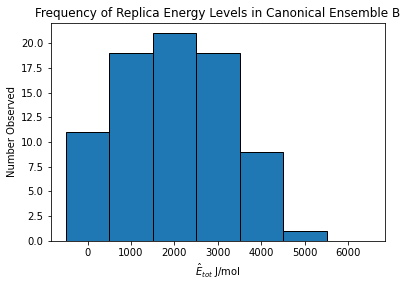

In [8]:
replica_Eis = np.array([2000, 3000, 3000, 2000, 4000, 3000, 2000, 4000, 2000, 5000, 2000, 4000, 1000, 0, 2000, 2000, 4000, 3000, 3000, 3000, 2000, 2000, 0, 1000, 2000,1000,2000,1000,1000,3000,2000,0,1000,1000,0,3000,0,3000,4000,3000,2000,0,3000,3000,1000,0,2000,4000,4000,1000,4000,2000,1000,1000,1000,2000,0,3000,2000,3000,0,1000,4000,1000,3000,1000,3000,1000,0,3000,0,3000,2000,1000,3000,2000,2000,1000,1000,2000])
plt.hist(replica_Eis, align='left', bins=[0,1000,2000,3000,4000,5000,6000,7000], edgecolor='black')
plt.xlabel('$\hat{E}_{tot}$ J/mol')
plt.ylabel('Number Observed')
plt.title('Frequency of Replica Energy Levels in Canonical Ensemble B')
print('Average: ', sum(replica_Eis)/len(replica_Eis))

unique, counts = np.unique(replica_Eis, return_counts = True)

### Problem 6.8C    
> The theoretical average of the ensemble is 2218.9 J/mol which is larger than the observed average of 1987.5 J/mol. The most probable theoretical value is 2000 J/mol which is in line with the observed data.

In [9]:
R = 8.3145 #J/K
T = 300 #K

beta_adj = 1/(R*T)
Q = 1 + 3*np.exp(-1000*beta_adj) + 6*np.exp(-2000*beta_adj) + 7*np.exp(-3000*beta_adj) + 6*np.exp(-4000*beta_adj) + 3*np.exp(-5000*beta_adj) + np.exp(-6000*beta_adj)

p1 = 1/Q
p2 = 3*np.exp(-1000*beta_adj)/Q
p3 = 6*np.exp(-2000*beta_adj)/Q
p4 = 7*np.exp(-3000*beta_adj)/Q
p5 = 6*np.exp(-4000*beta_adj)/Q
p6 = 3*np.exp(-5000*beta_adj)/Q
p7 = np.exp(-6000*beta_adj)/Q


probs = [p1, p2, p3, p4, p5, p6, p7]
energies = ['0','1000','2000','3000','4000','5000','6000']
'''plt.bar(energies, probs)
plt.title('Probabilities of Each Replica Energy Level as Predicted by Canonical Partition Function')
plt.ylabel('Probability')
plt.xlabel('$\hat{E}_{tot}$');''';

Theoretical Average:  2218.9446923435016


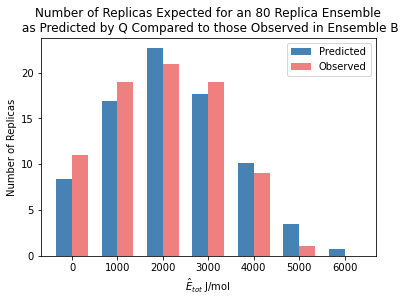

In [10]:
predicted_counts = [80*i for i in probs]

x = np.arange(len(energies))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted_counts, width, label='Predicted', color='steelblue')
rects2 = ax.bar(x + width/2, [*counts, 0], width, label='Observed', color='lightcoral')
ax.set_xticks(x)
ax.set_xticklabels(energies)
ax.legend()

_sum = 0

for i,j in enumerate(energies):
    _sum += int(j) * predicted_counts[i]
average_theoretical = _sum/sum(predicted_counts)
print('Theoretical Average: ', average_theoretical)

plt.title('Number of Replicas Expected for an 80 Replica Ensemble\n as Predicted by Q Compared to those Observed in Ensemble B')
plt.ylabel('Number of Replicas')
plt.xlabel('$\hat{E}_{tot}$ J/mol');

### Problem 6.9A     
> The mean value is 725 J/mol the most frequent value is 0 J/mol

Average:  725.0


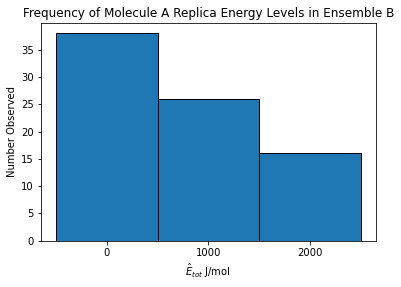

In [11]:
ensemble_a1_B = [1000, 2000, 2000, 0, 0, 1000, 1000, 1000, 1000, 1000, 1000, 0, 1000, 2000, 0, 0, 1000, 2000, 0, 0, 1000, 2000, 0, 0, 1000, 0, 1000, 0, 1000, 2000, 0, 0, 1000, 1000, 2000, 1000, 1000, 0, 0, 2000, 0, 1000, 2000, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 2000, 0, 2000, 0, 1000, 1000, 2000, 1000, 0, 1000, 2000, 0, 1000, 2000, 0, 0, 2000, 1000, 0, 0, 1000, 0, 0, 0, 0, 2000, 0, 0]
plt.hist(ensemble_a1_B, align='left', bins=[0,1000,2000, 3000], edgecolor='black')
plt.xlabel('$\hat{E}_{tot}$ J/mol')
plt.ylabel('Number Observed')
plt.title('Frequency of Molecule A Replica Energy Levels in Ensemble B')
plt.xticks([0,1000,2000])
print('Average: ', sum(ensemble_a1_B)/len(ensemble_a1_B))

unique2, counts2 = np.unique(ensemble_a1_B, return_counts = True)

### Problem 6.9B     
> 

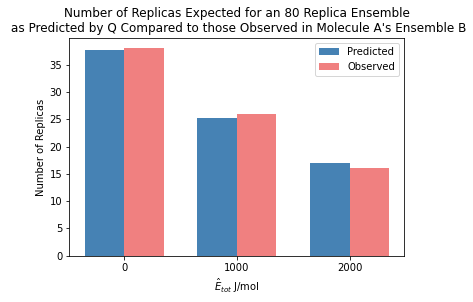

In [12]:
Q_sm = 1 + np.exp(-1000 * beta_adj) + np.exp(-2000*beta_adj)

p1 = 1/Q_sm
p2 = np.exp(-1000 * beta_adj)/Q_sm
p3 = np.exp(-2000 * beta_adj)/Q_sm

probs2 = [p1,p2,p3]
energies2 = [0,1000,2000]



predicted_counts2 = [80*i for i in probs2]

x = np.arange(len(energies2))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted_counts2, width, label='Predicted', color='steelblue')
rects2 = ax.bar(x + width/2, counts2, width, label='Observed', color='lightcoral')
ax.set_xticks(x)
ax.set_xticklabels(energies2)
ax.legend()

plt.title('Number of Replicas Expected for an 80 Replica Ensemble\n as Predicted by Q Compared to those Observed in Molecule A\'s Ensemble B')
plt.ylabel('Number of Replicas')
plt.xlabel('$\hat{E}_{tot}$ J/mol');

### Problem 6.10A     
> The mean energy level of the combined ensemble is 2200 J/mol. The most frequent replica energy is 2000 J/mol. This compares nicely to the three particle model from Problem 6.8B because the three molecules are independent of one another, the partition functions that describe the behavior of the three molecules can be multiplied together to get the partition function for the combination ensemble. However this combination partition function is simply the partition function that describes the three particle sytem and thus the behavior of the combined ensemble is the same as the predicted behavior in Problem 6.8C with an exprected average of around 2218 J / mol and with 2000 J/mol being the most frequent replica energy which is a behavior we see in the histogram below!

Average:  2200.0


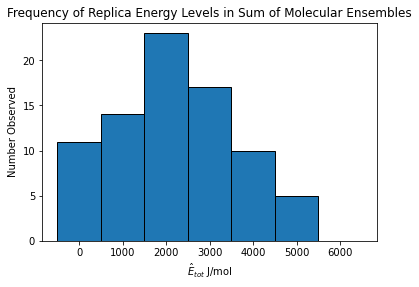

In [13]:
ensemble_b1_B = [1000, 0, 1000, 1000, 2000, 0, 1000, 1000, 2000, 0, 0, 1000, 1000, 2000, 1000, 0, 1000, 0, 1000, 0, 0, 0, 0, 0, 1000, 0, 1000, 1000, 2000, 0, 1000, 1000, 1000, 2000, 1000, 0, 0, 0, 0, 1000, 0, 1000, 0, 1000, 2000, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 0, 2000, 2000, 0, 1000, 0, 1000, 2000, 0, 0, 1000, 0, 1000, 0, 0, 0, 0, 1000, 2000, 0, 2000, 1000, 0, 0, 1000, 1000]
ensemble_c1_B = [0, 0, 2000, 0, 2000, 0, 0, 0, 2000, 2000, 2000, 0, 0, 1000, 0, 2000, 2000, 2000, 1000, 0, 0, 1000, 0, 0, 0, 2000, 1000, 2000, 2000, 0, 0, 2000, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 2000, 0, 0, 0, 0, 0, 0, 2000, 2000, 2000, 0, 0, 2000, 0, 1000, 0, 0, 1000, 0, 1000, 0, 1000, 1000, 2000, 1000, 2000, 0, 2000, 2000, 2000, 2000, 2000, 1000, 2000, 0, 2000, 1000, 0]
new_ensemble =[]

for i,j in enumerate(ensemble_a1_B):
    new_ensemble.append(j+ensemble_b1_B[i]+ensemble_c1_B[i])

plt.hist(new_ensemble, align='left', bins=[0,1000,2000,3000,4000,5000,6000,7000], edgecolor='black')
plt.xlabel('$\hat{E}_{tot}$ J/mol')
plt.ylabel('Number Observed')
plt.title('Frequency of Replica Energy Levels in Sum of Molecular Ensembles')
print('Average: ', sum(new_ensemble)/len(new_ensemble))

### Problem 6.10B    
> As we can see below the partition function of the three particle model used in Problem 6.8 is just the combined independent molecules' partition function which is simply the product of the three simgle molecule Qs. 

In [14]:
new_Q = Q_sm**3 #Multiply the Q from the single molecule ensembles times itself 3x to get combined ensemble Q
old_Q = Q #The Q from problem 6.8C

print(new_Q, old_Q) #The two are the same confirming suspicions from 6.10A

9.504261840887137 9.504261840887136
